In [106]:
import numpy as np 
import pandas as pd
import datetime

import scipy.stats as ss
from scipy.stats import norm

from sklego.preprocessing import RepeatingBasisFunction as RBF

import statsmodels.stats.stattools as stats
import statsmodels.formula.api as sm
import statsmodels.api as sma
import statsmodels.tsa.api as smt
import statsmodels as stat

import linearmodels as lm

from workalendar.europe import NetherlandsWithSchoolHolidays as NL

import matplotlib.pyplot as plt 
import hvplot.pandas
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('cleaned_data_reduced.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = (df.drop('Unnamed: 0', axis=1)
      .set_index('timestamp')
      .resample('D').sum())
df = df.loc['2015':'2020']
df = df.rename(columns={"Pay pax": "Pay_pax"})
df.tail()

,Pax,Pay_pax,BookedPayPax
timestamp,,,
2020-12-27,8.0,8.0,24.0
2020-12-28,12.0,11.0,11.0
2020-12-29,241.0,236.0,191.0
2020-12-30,8.0,8.0,8.0
2020-12-31,12.0,0.0,0.0


In [3]:
calendar = NL(region='south', carnival_instead_of_spring=True)
all_holidays = []
for i in list(df.index.year.unique())[1:]:
    for j in calendar.holidays(i):
        all_holidays.append(j[0])
        
months ={'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6,
         'July':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

In [17]:
def Create_Fixed_Features(df): 
    fixed_features = pd.DataFrame(index=df.index)
    fixed_features['Time'] = [i for i in range(len(fixed_features))]
    fixed_features['Days_of_year'] = fixed_features.index.dayofyear
    fixed_features['Holidays'] = [1 if i in all_holidays else 0 for i in fixed_features.index]
    fixed_features['Week'] = fixed_features.index.week
    fixed_features['Months'] = fixed_features.index.month
    
    for i in list(months.keys()):
        fixed_features[i] = [1 if months[i]==fixed_features['Months'][j] else 0 for j in range(len(fixed_features)) ]
        
    rbf = RBF(n_periods=12,
             column="Days_of_year",
             input_range=(1,365),
             remainder="drop")
    rbf.fit(fixed_features)
    radials = pd.DataFrame(index=fixed_features.index,
                           data=rbf.transform(fixed_features))
    fixed_features[list(months.keys())] = radials    
        
    return fixed_features


def Create_Variable_Features(df):
    var_features = pd.DataFrame(index=df.index)
    var_features ['RM_10_L1'] = df['Pay_pax'].rolling(10).mean().shift(1)
    var_features ['SD_30_L1'] = df['Pay_pax'].rolling(30).std().shift(1)
    var_features ['PP_L1'] = df['Pay_pax'].shift(1)
    
    var_features ['RM_10_L7'] = df['Pay_pax'].rolling(10).mean().shift(7)
    var_features ['SD_30_L7'] = df['Pay_pax'].rolling(30).std().shift(7)
    var_features ['PP_L7'] = df['Pay_pax'].shift(7)
    return var_features

In [179]:
def get_OneStep_Prediction(df, date_start_training, date_end_training, forecast_period = 28, mse_display=True): 
    '''
    Function 
    
    
    '''

    end_training = pd.to_datetime(date_end_training)
    beg_training = pd.to_datetime(date_start_training)
    up_df = df[beg_training:end_training].copy()
    all_predictions = pd.DataFrame(columns=['OneStep_Pred'])

    initial_features = Create_Variable_Features(df[beg_training:end_training]).join(Create_Fixed_Features(df[beg_training:end_training]))
    initial_training = initial_features.join(df['Pay_pax'][beg_training:end_training ])[:-1]
    initial_validation = initial_features.iloc[-1,:]

    my_formula = "Pay_pax ~ Time + Holidays + RM_10_L7 + PP_L7  + SD_30_L7 + "+' + '.join(list(months.keys()))
    rslt = sm.ols(formula=my_formula, data=initial_training).fit()
    ypred_out = rslt.predict(initial_validation)
    all_predictions = all_predictions.append(pd.DataFrame(ypred_out, columns=['OneStep_Pred']))


    for i in range(1,forecast_period):
        # update of the training set 
        new_date = end_training + datetime.timedelta(days=i)
        up_fixed_features = pd.DataFrame(Create_Fixed_Features(df[:new_date]).iloc[-1,:]).transpose()
        #up_var_features
        up_df = up_df.append(pd.DataFrame(index=pd.DatetimeIndex([new_date]), columns=['Pax', 'Pay_pax', 'BookedPayPax']))
        up_df.loc[pd.DatetimeIndex([new_date])] = [None, ypred_out, None]
        up_var_features =  pd.DataFrame(Create_Variable_Features(up_df[:new_date]).iloc[-1,:]).transpose()
        
        initial_features = initial_features.append(up_fixed_features.join(up_var_features))
        initial_validation = initial_features.iloc[-1,:]
        initial_training = initial_features.join(df['Pay_pax'][:end_training ])[:-1]

        my_formula = "Pay_pax ~ Time + Holidays + RM_10_L7 + PP_L7  + SD_30_L7 + "+' + '.join(list(months.keys()))
        rslt = sm.ols(formula=my_formula, data=initial_training).fit()
        ypred_out = rslt.predict(initial_validation)
        all_predictions = all_predictions.append(pd.DataFrame(ypred_out, columns=['OneStep_Pred']))


    
    mse2 =np.sqrt(((df['Pay_pax'][end_training: end_training+datetime.timedelta(days=forecast_period)] - all_predictions['OneStep_Pred']) ** 2).mean())
    if mse_display==True:
        print('The Root Mean Squared Error of our forecast is {}'.format(round(mse2, 2)))
    
    return all_predictions, mse2

In [184]:
pred, rmse = get_OneStep_Prediction(df, date_start_training='2016-01-01', date_end_training='2019-01-01', forecast_period = 28)

The Root Mean Squared Error of our forecast is 986.27


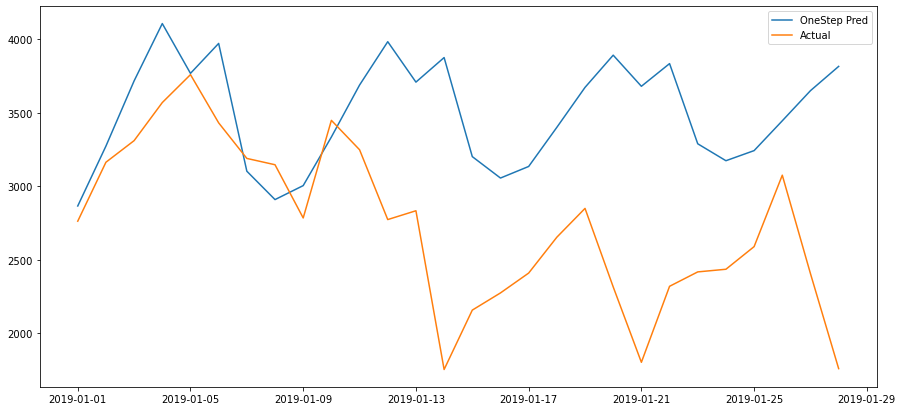

In [185]:
plt.figure(figsize=(15,7))
plt.plot(pred, label='OneStep Pred')
plt.plot(df['Pay_pax']['01-01-2019':'28-01-2019'], label='Actual')
plt.legend(loc='best')
plt.show()

In [190]:
def Cross_Val(df, training_period, forecast_period, options='RW', fig_display=True):
    '''
    
    Function to perform timeseries forecasting validation:
    INPUT: Training_period = int - length of the training sample
    INPUT: Forecasting_period = int - amount of days to predict
    INPUT: options = str - takes either RW (Rolling Windows) or EX (Expending window)
    OUTPUT: all_mse = list - all RMSE values
    OUTPUT: all_predic = list - all out of samples predictions
    
    '''
    all_mse = []
    all_predic = []
    start_training_date = df['Pay_pax'].index[0]
    end_training_date = df['Pay_pax'].index[training_period]
    nb_iter = round(len(df['Pay_pax'][end_training_date:])/7) #numbers of periods to predict
    
    
    # first iteration 
    actual_data = df[start_training_date: end_training_date + datetime.timedelta(days=forecast_period)]
    onestep_pred, mse = get_OneStep_Prediction(actual_data,
                                                         date_start_training=start_training_date,
                                                         date_end_training=end_training_date,
                                                         mse_display=False)

    all_mse.append(mse)
    all_predic.append(onestep_pred)

    
    if options=='RW':
        for i in range(1, nb_iter):
            #print('iteration #'+str(i))
            start_training_date += datetime.timedelta(days=7)
            end_training_date += datetime.timedelta(days=7)
            actual_data = df[end_training_date: end_training_date + datetime.timedelta(days=forecast_period)]
            onestep_pred, mse = get_OneStep_Prediction(actual_data,
                                                         date_start_training=start_training_date,
                                                         date_end_training=end_training_date,
                                                         mse_display=False)
            all_mse.append(mse)
            all_predic.append(onestep_pred)
            
    elif options == 'EX':
        for i in range(1, nb_iter):
            end_training_date += datetime.timedelta(days=7) 
            actual_data = df[end_training_date: end_training_date + datetime.timedelta(days=forecast_period)]
            onestep_pred, mse = get_OneStep_Prediction(actual_data,
                                                         date_start_training=start_training_date,
                                                         date_end_training=end_training_date,
                                                         mse_display=False)
            all_mse.append(mse)
            all_predic.append(onestep_pred)
        
    else: 
        print('Options type not recognized: Please choose either RW or EX')
        return None
        
        
    if fig_display==True: 
        
        pd.DataFrame(all_mse).plot(figsize=(15,5))
        
    
        
        
    return all_mse, all_predic
    

In [191]:
Cross_Val(df, training_period=500, forecast_period=28, options='RW', fig_display=True)

ValueError: zero-size array to reduction operation maximum which has no identity